In [ ]:
import tensorflow as tf
import os
import time
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import time
from keras.utils.generic_utils import get_custom_objects
from google.colab import drive

drive.mount('/content/drive')

def listaArchivos(path):
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(path+'/'+i.name)
    return filelist

def decode(serialized_example):
    featuress= tf.io.parse_single_example(
    serialized_example,
    features={'noisy': tf.io.FixedLenFeature(shape=(7225,), dtype= tf.float32),#85,85
      'clean':tf.io.FixedLenFeature(shape=(7225,), dtype=tf.float32),
      'NLM':tf.io.FixedLenFeature(shape=(81920,), dtype=tf.float32),#64,64,20
    })
    return featuress

# normal slicing




Mounted at /content/drive


# synthetic

In [ ]:
foldertrain = "./drive/MyDrive/dataNLM/synthetictfrecord"# ./cleanpart_1/train
#start = time.perf_counter()
#randomize the files


# data geneerator
ds_train = tf.data.TFRecordDataset(listaArchivos(foldertrain),num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    
    return  noisy,clean

ds_train = ds_train.map(tf_slicing2)
# Getting the model OF CNNNL Complex architecture


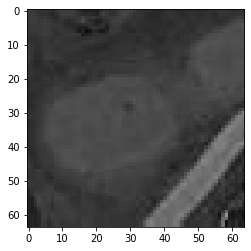

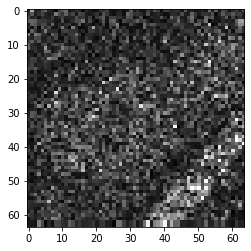

In [ ]:
import matplotlib.pyplot as plt
for decoded_imgs,batch_y in ds_train.take(1):
  #print(decoded_imgs[:,:,0],batch_y)
  decoded_imgs = decoded_imgs[:,:,0]
  test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgs,np.log(256))# first denormalize
  test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
  decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)
  test_y= tf.clip_by_value(test_y, 0, 255)
  plt.imshow(tf.squeeze(test_y), cmap='gray', vmin=0, vmax=255)
  plt.show()
  plt.imshow(tf.squeeze(decoded_imgs), cmap='gray', vmin=0, vmax=255)
  plt.show()

In [ ]:
import math
import cv2
from google.colab.patches import cv2_imshow

get_custom_objects().update({'custom_loss': custom_loss})
modelF2 = tf.keras.models.load_model('./drive/MyDrive/dataNLM/CNNLM1Iter')

# Getting the model OF CNNNL easy Architecture



1/1 [==============================] - 2s 2s/step


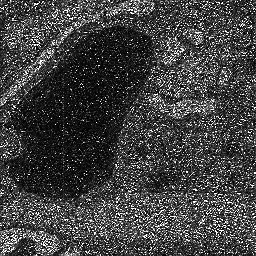

In [ ]:
# Complex NLCNN
# Getting the model OF denseNL easy Architecture

Num=16
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF2.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)

imageTot= np.zeros((256,256))


imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[6])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[9])[:,:]
imageTot[0*64:(0+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[13])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[14])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[8])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[10])[:,:]
imageTot[1*64:(1+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[4])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[7])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[5])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[12])[:,:]
imageTot[2*64:(2+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[3])[:,:]
imageTot[3*64:(3+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[1])[:,:]
imageTot[3*64:(3+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[15])[:,:]
imageTot[3*64:(3+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[2])[:,:]
imageTot[3*64:(3+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[11])[:,:]


cv2_imshow(imageTot)
cv2.imwrite('NLCNN.png',imageTot)
# getting the noisy data
trainD=tf.math.multiply(batch_x,np.log(256))
trainD=tf.math.add(tf.math.exp(trainD),-1)

trainD=trainD[:,:,:,1]# Noisy image

1/1 [==============================] - 0s 164ms/step


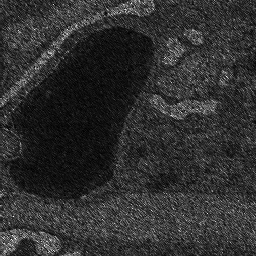

In [ ]:
#Simple NLCNN
modelF = tf.keras.models.load_model('./drive/MyDrive/dataNLM/Dense3')
Num=16
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)

imageTot= np.zeros((256,256))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[6])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[9])[:,:]
imageTot[0*64:(0+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[13])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[14])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[8])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[10])[:,:]
imageTot[1*64:(1+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[4])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[7])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[5])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[12])[:,:]
imageTot[2*64:(2+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[3])[:,:]
imageTot[3*64:(3+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[1])[:,:]
imageTot[3*64:(3+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[15])[:,:]
imageTot[3*64:(3+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[2])[:,:]
imageTot[3*64:(3+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[11])[:,:]


cv2_imshow(imageTot)
cv2.imwrite('SimpleNLCNN.png',imageTot)
# getting the noisy data
trainD=tf.math.multiply(batch_x,np.log(256))
trainD=tf.math.add(tf.math.exp(trainD),-1)

trainD=trainD[:,:,:,1]# Noisy image

True

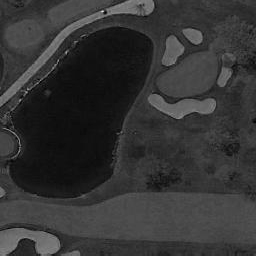

In [ ]:
imageTot= np.zeros((256,256))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(test_y[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(test_y[6])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(test_y[9])[:,:]
imageTot[0*64:(0+1)*64,3*64:(3+1)*64]=tf.squeeze(test_y[13])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(test_y[14])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(test_y[8])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(test_y[10])[:,:]
imageTot[1*64:(1+1)*64,3*64:(3+1)*64]=tf.squeeze(test_y[4])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(test_y[7])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(test_y[5])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(test_y[12])[:,:]
imageTot[2*64:(2+1)*64,3*64:(3+1)*64]=tf.squeeze(test_y[3])[:,:]
imageTot[3*64:(3+1)*64,0*64:(0+1)*64]=tf.squeeze(test_y[1])[:,:]
imageTot[3*64:(3+1)*64,1*64:(1+1)*64]=tf.squeeze(test_y[15])[:,:]
imageTot[3*64:(3+1)*64,2*64:(2+1)*64]=tf.squeeze(test_y[2])[:,:]
imageTot[3*64:(3+1)*64,3*64:(3+1)*64]=tf.squeeze(test_y[11])[:,:]



cv2_imshow(imageTot)
# getting the noisy data
trainD=tf.math.multiply(batch_x,np.log(256))
trainD=tf.math.add(tf.math.exp(trainD),-1)

trainD=trainD[:,:,:,1]# Noisy image

In [ ]:
batch_x.shape

TensorShape([16, 64, 64, 21])

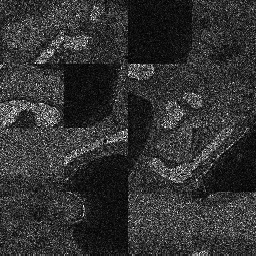

In [ ]:
#Noisy
imageTot= np.zeros((256,256))
batch_x2=tf.math.multiply(batch_x,np.log(256))
batch_x2=tf.math.add(tf.math.exp(batch_x2),-1)
batch_x2= tf.clip_by_value(batch_x2, 0, 255)
batch_x3=batch_x2[:,:,:,0]
for i in range(16):# reconstructing the image, i Think its ordered, lets see
  h=i % 4
  w=math.floor(i/4)
  imageTot[h*64:(h+1)*64,w*64:(w+1)*64]=tf.squeeze(batch_x3[i])[:,:]

cv2_imshow(imageTot)
# getting the noisy data


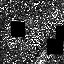

In [ ]:
d=decoded_imgs[0].numpy()[:,:,0]
type(d)
cv2_imshow(d)

# Real

In [ ]:
foldertrain = "./drive/MyDrive/dataNLM/realtfrecord"# ./cleanpart_1/train
#start = time.perf_counter()
#randomize the files


listF=np.array(listaArchivos(foldertrain))
np.sort(listF) 
listF=list(listF)


# data geneerator
ds_train = tf.data.TFRecordDataset(listF[::-1][9:],num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    
    return  noisy,clean

ds_train = ds_train.map(tf_slicing2)
# Getting the model OF CNNNL Complex architecture


In [ ]:
# Complex NLCNN
# Getting the model OF denseNL easy Architecture

Num=9
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF2.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)

imageTot= np.zeros((256,256))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(test_y[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(test_y[6])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(test_y[9])[:,:]
imageTot[0*64:(0+1)*64,3*64:(3+1)*64]=tf.squeeze(test_y[13])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(test_y[14])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(test_y[8])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(test_y[10])[:,:]
imageTot[1*64:(1+1)*64,3*64:(3+1)*64]=tf.squeeze(test_y[4])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(test_y[7])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(test_y[5])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(test_y[12])[:,:]
imageTot[2*64:(2+1)*64,3*64:(3+1)*64]=tf.squeeze(test_y[3])[:,:]
imageTot[3*64:(3+1)*64,0*64:(0+1)*64]=tf.squeeze(test_y[1])[:,:]
imageTot[3*64:(3+1)*64,1*64:(1+1)*64]=tf.squeeze(test_y[15])[:,:]
imageTot[3*64:(3+1)*64,2*64:(2+1)*64]=tf.squeeze(test_y[2])[:,:]
imageTot[3*64:(3+1)*64,3*64:(3+1)*64]=tf.squeeze(test_y[11])[:,:]


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


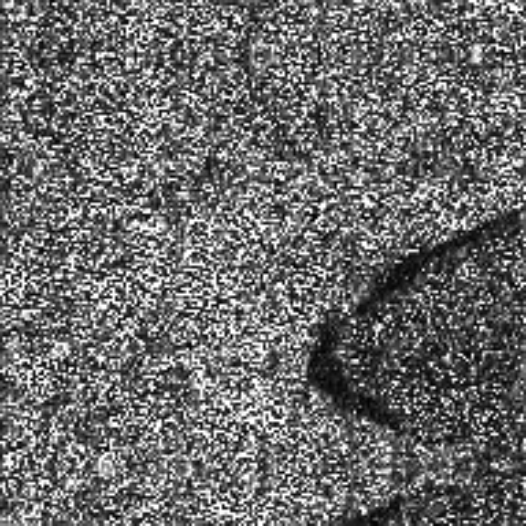

In [ ]:
Num=9
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF2.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)
imageTot= np.zeros((192,192))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[1])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[2])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[3])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[4])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[5])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[6])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[7])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[8])[:,:]

cv2.imwrite("realsarstartNLCNN.png",imageTot)
cv2_imshow(cv2.resize(imageTot, (526,526)))

1/1 [==============================] - 0s 35ms/step


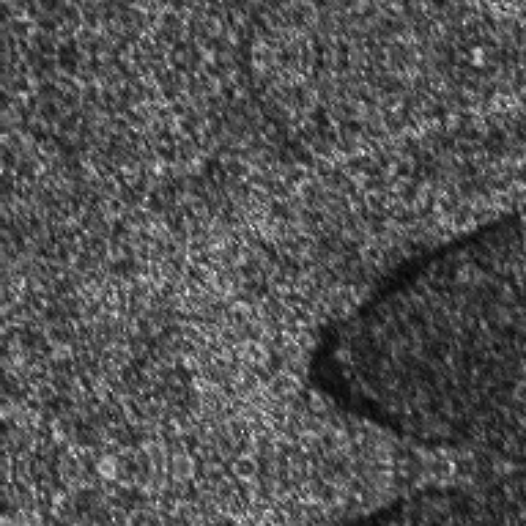

In [ ]:
Num=9
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)
imageTot= np.zeros((192,192))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[1])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[2])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[3])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[4])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[5])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[6])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[7])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[8])[:,:]

cv2.imwrite("realsarstartSimpleNLCNN.png",imageTot)
cv2_imshow(cv2.resize(imageTot, (526,526)))

# Benchmark

In [ ]:
foldertrain = "./drive/MyDrive/dataNLM/Square"# ./cleanpart_1/train
#start = time.perf_counter()
#randomize the files


listF=np.array(listaArchivos(foldertrain))
np.sort(listF) 
listF=list(listF)
listF.sort()
LIst= [*listF[:2],*listF[8:],*listF[2:8]]
LIst

# data geneerator
ds_train = tf.data.TFRecordDataset(LIst,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    
    return  noisy,clean

ds_train = ds_train.map(tf_slicing2)
# Getting the model OF CNNNL Complex architecture


1/1 [==============================] - 3s 3s/step


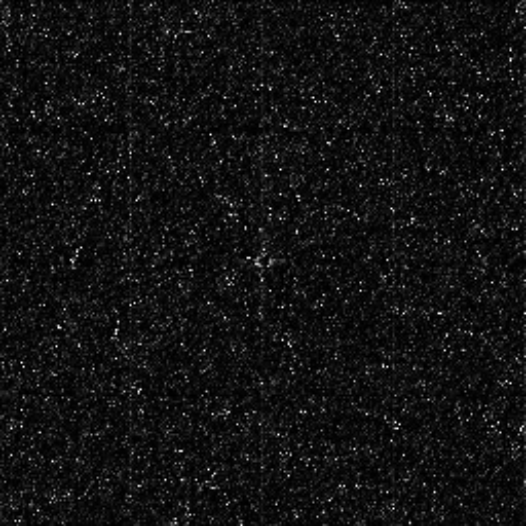

In [ ]:
Num=64
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF2.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)

imageTot= np.zeros((256,256))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[1])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[2])[:,:]
imageTot[0*64:(0+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[3])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[4])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[5])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[6])[:,:]
imageTot[1*64:(1+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[7])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[8])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[9])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[10])[:,:]
imageTot[2*64:(2+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[11])[:,:]
imageTot[3*64:(3+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[12])[:,:]
imageTot[3*64:(3+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[13])[:,:]
imageTot[3*64:(3+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[14])[:,:]
imageTot[3*64:(3+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[15])[:,:]

cv2.imwrite("CornerNLCNN.png",imageTot)
cv2_imshow(cv2.resize(imageTot, (526,526)))

1/1 [==============================] - 0s 77ms/step


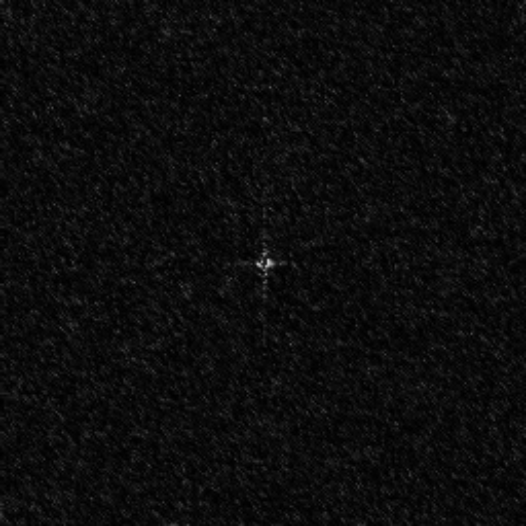

In [ ]:
Num=16
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)

imageTot= np.zeros((256,256))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[1])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[2])[:,:]
imageTot[0*64:(0+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[3])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[4])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[5])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[6])[:,:]
imageTot[1*64:(1+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[7])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[8])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[9])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[10])[:,:]
imageTot[2*64:(2+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[11])[:,:]
imageTot[3*64:(3+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[12])[:,:]
imageTot[3*64:(3+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[13])[:,:]
imageTot[3*64:(3+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[14])[:,:]
imageTot[3*64:(3+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[15])[:,:]

cv2.imwrite("CornerSimpleNLCNN.png",imageTot)
cv2_imshow(cv2.resize(imageTot, (526,526)))

# Square

In [ ]:
foldertrain = "./drive/MyDrive/dataNLM/benchmarktfrecord"# ./cleanpart_1/train
#start = time.perf_counter()
#randomize the files


listF=np.array(listaArchivos(foldertrain))
np.sort(listF) 
listF=list(listF)
listF.sort()
listF
LIst1= [*listF[:2],*listF[8:16],*listF[2:8]]
listF2=listF[16:32]
LIst2= [*listF2[:2],*listF2[8:16],*listF2[2:8]]
listF3=listF[32:48]
LIst3= [*listF3[:2],*listF3[8:16],*listF3[2:8]]
listF4=listF[48:64]
LIst4= [*listF4[:2],*listF4[8:16],*listF4[2:8]]

# data geneerator
ds_train = tf.data.TFRecordDataset(LIst4,num_parallel_reads=tf.data.experimental.AUTOTUNE,buffer_size=None).map(decode)
#print(time.perf_counter()-start)
# Disable the order so its faster to run
# try the simple function of slicing
#print(time.perf_counter()-start)# 31 segundos en cortar 12 gigas, aunque no las carga del todo. solo si las traigo a colación las carga
# Slicing normal didnt seemn to work well.

# custom loss function
import keras.backend as K
import sklearn

class CustomAccuracySAR2(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        #y_true=y_true[0]
        y_true,y_pred=tf.math.multiply(y_true,np.log(256)),tf.math.multiply(y_pred,np.log(256))# first denormalize
        y_true,y_pred=tf.math.add(tf.math.exp(y_true),-1),tf.math.add(tf.math.exp(y_pred),-1)# then add subtract the slide
        # Clipping
        y_true= tf.clip_by_value(y_true, 0, 255)
        y_pred= tf.clip_by_value(y_pred, 0, 255)
        denom = tf.math.sqrt(tf.math.multiply(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01)))# the 0.02 is to avoid the problem with the logarithm
        SARdist= tf.math.log(tf.math.divide(tf.math.add(tf.math.add(y_pred,0.01),tf.math.add(y_true,0.01))+0.001,denom + 0.001))
        return SARdist
    
def custom_loss(y_true, y_pred):
    l_1 = 0.7
    l_2 = 0.3
    mse = tf.keras.losses.MeanSquaredError()
    SARdist = CustomAccuracySAR2()
    loss_Sard = SARdist(y_true , y_pred)
    loss_mse = mse(y_true , y_pred)
    total_loss = l_1*loss_mse + l_2*loss_Sard.numpy()
    return total_loss

def sliceN2(data):
    data = tf.reshape(data, [85,85], name="noisy")
    data=tf.convert_to_tensor(data[11:75,11:75])
    data=tf.reshape(data,[64,64,1],name='noisy')
    return data
def sliceC(data):
    data = tf.reshape(data, [85,85], name="clean")
    data=tf.convert_to_tensor(data[11:75,11:75])
    return data
def sliceNLM(data):
    data = tf.reshape(data, [64,64,20], name="NLM")
    return data
#[image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
#image.set_shape(im_shape)
def tf_slicing2(elem):
    clean=elem['clean']
    noisy=elem['noisy']
    NLM=elem['NLM']
    
    [clean,] = tf.py_function(sliceC,[clean], [tf.float32])#[clean,] =
    [noisy,] = tf.py_function(sliceN2,[noisy], [tf.float32])
    [NLM,] = tf.py_function(sliceNLM,[NLM], [tf.float32])
    noisy = tf.concat(axis=2, values=[noisy,NLM,])# concatenating the NLM with the noisy to get only one x
    
    return  noisy,clean

ds_train = ds_train.map(tf_slicing2)
# Getting the model OF CNNNL Complex architecture


1/1 [==============================] - 0s 48ms/step


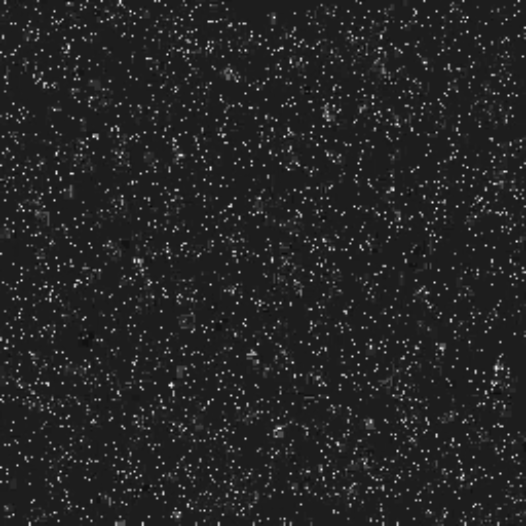

In [ ]:
#CNN 1st square
Num=16
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)

imageTot= np.zeros((256,256))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[1])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[2])[:,:]
imageTot[0*64:(0+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[3])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[4])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[5])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[6])[:,:]
imageTot[1*64:(1+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[7])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[8])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[9])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[10])[:,:]
imageTot[2*64:(2+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[11])[:,:]
imageTot[3*64:(3+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[12])[:,:]
imageTot[3*64:(3+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[13])[:,:]
imageTot[3*64:(3+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[14])[:,:]
imageTot[3*64:(3+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[15])[:,:]

cv2.imwrite("SquareSimpleNLCNN.png",imageTot)
cv2_imshow(cv2.resize(imageTot, (526,526)))

In [ ]:
#CNN 1st square
Num=16
for batch_x,batch_y in ds_train.batch(Num).take(Num):# predicting some values
    batch_x= tf.clip_by_value(batch_x, 0,1)
    decoded_imgsF = modelF2.predict(batch_x)
test_y,decoded_imgs2=tf.math.multiply(batch_y,np.log(256)),tf.math.multiply(decoded_imgsF,np.log(256))# first denormalize
test_y,decoded_imgs=tf.math.add(tf.math.exp(test_y),-1),tf.math.add(tf.math.exp(decoded_imgs2),-1)# then add subtract the slide
decoded_imgs= tf.clip_by_value(decoded_imgs, 0, 255)

imageTot= np.zeros((256,256))

imageTot[0*64:(0+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[0])[:,:]
imageTot[0*64:(0+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[1])[:,:]
imageTot[0*64:(0+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[2])[:,:]
imageTot[0*64:(0+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[3])[:,:]
imageTot[1*64:(1+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[4])[:,:]
imageTot[1*64:(1+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[5])[:,:]
imageTot[1*64:(1+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[6])[:,:]
imageTot[1*64:(1+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[7])[:,:]
imageTot[2*64:(2+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[8])[:,:]
imageTot[2*64:(2+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[9])[:,:]
imageTot[2*64:(2+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[10])[:,:]
imageTot[2*64:(2+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[11])[:,:]
imageTot[3*64:(3+1)*64,0*64:(0+1)*64]=tf.squeeze(decoded_imgs[12])[:,:]
imageTot[3*64:(3+1)*64,1*64:(1+1)*64]=tf.squeeze(decoded_imgs[13])[:,:]
imageTot[3*64:(3+1)*64,2*64:(2+1)*64]=tf.squeeze(decoded_imgs[14])[:,:]
imageTot[3*64:(3+1)*64,3*64:(3+1)*64]=tf.squeeze(decoded_imgs[15])[:,:]

cv2.imwrite("SquareNLCNN.png",imageTot)

1/1 [==============================] - 2s 2s/step


True

In [ ]:
imageTot.shape

(256, 256)

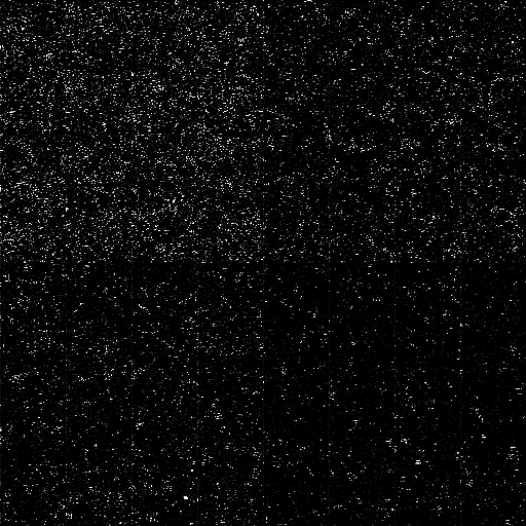

In [ ]:
# Generating the square image
imageTot= np.zeros((512,512))


im0=cv2.imread("SquareNLCNN1.png")
im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)
im1=cv2.imread("SquareNLCNN2.png")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2=cv2.imread("SquareNLCNN3.png")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
im3=cv2.imread("SquareNLCNN4.png")
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

imageTot[0*256:(0+1)*256,0*256:(0+1)*256]=im0[:,:]
imageTot[0*256:(0+1)*256,1*256:(1+1)*256]=im1[:,:]
imageTot[1*256:(1+1)*256,0*256:(0+1)*256]=im2[:,:]
imageTot[1*256:(1+1)*256,1*256:(1+1)*256]=im3[:,:]

cv2.imwrite("SquareNLCNN.png",imageTot)
cv2_imshow(cv2.resize(imageTot, (526,526)))

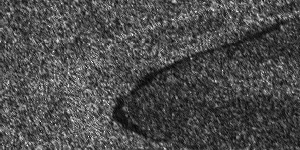

In [ ]:
#Unite the RealSARimages
# Generating the square image
imageTot= np.zeros((150,300))


im0=cv2.imread("realsarstartSimpleNLCNN.png")
im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)
im1=cv2.imread("realsarendSimpleNLCNN.png")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)


imageTot[0*150:(0+1)*150,0*150:(0+1)*150]=im0[21:171,:150]
imageTot[0*150:(0+1)*150,1*150:(1+1)*150]=im1[21:171,42:]

cv2.imwrite("realSARSimpleNLCNN.png",imageTot)
cv2_imshow(imageTot)



In [ ]:
imageTot.shape

(150, 300)

In [ ]:
im1=cv2.imread("Sar.png")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im1.shape

(150, 300)

# Finally Metrics of Real and synthetic Dataset

In [ ]:
pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=319cfb9d4c90c8cb7fcc7fab821f9211c598d1de3124eda65fd6cd57486c7945
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [ ]:
# Resultssss Synthetic
from sewar.full_ref import uqi,psnr,vifp,ssim #Visual Information Fidelity (VIF), Spatial Distortion Index (D_S)
import cv2
import sys
import os
import pandas as pd
from skimage import io, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
import numpy as np

def metrics(reference,comparison,psnr_data,uqi_data,ssim_data):# reference path and reference comparison to a given image with all metrics
    """ This function reference image and comparison to a given image with all metrics"""
    name=str(comparison).split('imagetest')[1][1:-4]# this gets only the name of the file
    imgref = cv2.imread(reference)
    imgref = cv2.cvtColor(imgref, cv2.COLOR_BGR2GRAY)# image comp is without noise
    imgcomp = cv2.imread(comparison)
    imgcomp = cv2.cvtColor(imgcomp, cv2.COLOR_BGR2GRAY)
    psnr_data[name]=psnr(imgref, imgcomp)
    uqi_data[name]=uqi(imgref, imgcomp)
    ssim_data[name]= ssim(imgref, imgcomp)[0]
    return psnr_data,uqi_data,ssim_data
  

def listaArchivos(path):####Get all the files in a directory
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(i.name)
    return filelist

def calcmetrics(): #Dataframe of all of the metrics in a directory
    """This function gets all the metrics from a given directory"""
    psnr_data={}
    uqi_data={}
    ssim_data={}
    listaimagenes=listaArchivos('./imagetest')
    reference='./imagetest/clean.jpg'
    for i in listaimagenes:
        print(i)
        i='./imagetest/'+i
        psnr_data,uqi_data,ssim_data=metrics(reference,i,psnr_data,uqi_data,ssim_data)
    dfObj = pd.DataFrame(psnr_data, index=[*range(0, len(psnr_data.keys()), 1)])
    dfObj2 = pd.DataFrame(uqi_data, index=[*range(0, len(psnr_data.keys()), 1)])
    dfObj4 = pd.DataFrame(ssim_data, index=[*range(0, len(psnr_data.keys()), 1)])
    frames = [dfObj, dfObj2, dfObj4]
    result = pd.concat( frames, axis=0)
    number=8# raro hay que cuadrarlo
    metricas = np.concatenate((np.repeat('PSNR',number, axis=0),np.repeat('UQI',number, axis=0), np.repeat('SSIM',number, axis=0)),axis=0)
    result['Metrica'] = metricas
    result=result.iloc[::number]
    cols = result.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    result = result[cols]
    return result


dataframesynth=calcmetrics()  
dataframesynth.to_csv("Metrics.csv",sep='\t')
dataframesynth

noisy_synthetic.jpg
clean.jpg
SimpleNLCNN.png
LeeSigma.png
SARCNN.png
Lee.png
NLCNN.png
LeeRefined.png


,Metrica,noisy_synthetic,clean,SimpleNLCNN,LeeSigma,SARCNN,Lee,NLCNN,LeeRefined
0,PSNR,18.237760,inf,20.804722,28.938789,20.821913,26.840075,12.087093,26.642844
0,UQI,0.867006,1.0,0.910601,0.985949,0.856220,0.977622,0.608256,0.975515
0,SSIM,0.254480,1.0,0.321778,0.762475,0.698607,0.625199,0.067950,0.605370


In [ ]:
dataframesynth.T.to_csv("Metrics.csv",sep='\t')

In [ ]:
dataframesynth.T.to_excel(("MetricsS.xlsx"))

In [ ]:
# Resultssss Real
from sewar.full_ref import uqi,psnr,vifp,ssim #Visual Information Fidelity (VIF), Spatial Distortion Index (D_S)
import cv2
import sys
import os
import pandas as pd
from skimage import io, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
import numpy as np

def metrics(comparison,Tamura_data,ENL_data,MoR_data):# reference path and reference comparison to a given image with all metrics
    """ This function reference image and comparison to a given image with all metrics"""
    name=str(comparison).split('imagetest')[1][2:-4]# this gets only the name of the file
    imgcomp = cv2.imread(comparison)
    imgcomp = cv2.cvtColor(imgcomp, cv2.COLOR_BGR2GRAY)
    Homogenousregion=imgcomp[90:129,145:184]
    imgN = cv2.imread("./imagetest2/noisy.png")# To compare for BIAS
    imgN = cv2.cvtColor(imgN, cv2.COLOR_BGR2GRAY)
    noisyHomo=imgN[90:129,145:184]
    Tamura_data[name]=np.sqrt(np.std(Homogenousregion)/np.mean(Homogenousregion)) # less better
    ENL_data[name]=((np.mean(Homogenousregion))**2)/(np.std(Homogenousregion))**2 # More better
    MoR_data[name]=np.mean(np.divide(noisyHomo, Homogenousregion))#Divide Noisy/filter should be equal
    return Tamura_data,ENL_data,MoR_data
  

def listaArchivos(path):####Get all the files in a directory
    """This function gets all the files in a directory"""
    filelist=[]
    with os.scandir(path) as entries:
        for i in entries:
            filelist.append(i.name)
    return filelist

def calcmetrics(): #Dataframe of all of the metrics in a directory
    """This function gets all the metrics from a given directory"""
    Tamura_data={}
    ENL_data={}
    MoR_data={}
    listaimagenes=listaArchivos('./imagetest2')
    for i in listaimagenes:
        print(i)
        i='./imagetest2/'+i
        Tamura_data,ENL_data,MoR_data=metrics(i,Tamura_data,ENL_data,MoR_data)
    dfObj = pd.DataFrame(Tamura_data, index=[*range(0, len(Tamura_data.keys()), 1)])
    dfObj2 = pd.DataFrame(ENL_data, index=[*range(0, len(Tamura_data.keys()), 1)])
    dfObj4 = pd.DataFrame(MoR_data, index=[*range(0, len(Tamura_data.keys()), 1)])
    frames = [dfObj, dfObj2, dfObj4]
    result = pd.concat( frames, axis=0)
    number=10# raro hay que cuadrarlo
    metricas = np.concatenate((np.repeat('Tamura',number, axis=0),np.repeat('ENL',number, axis=0), np.repeat('MoR',number, axis=0)),axis=0)
    result['Metrica'] = metricas
    result=result.iloc[::number]
    cols = result.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    result = result[cols]
    return result


dataframeReal=calcmetrics()  
dataframeReal.to_csv("MetricsSAR.csv",sep='\t')
dataframeReal

realSARNLCNN.png
Tempavg.png
realSARSimpleNLCNN.png
noisy.png
LeeSigma.png
BM3D.png
SARCNN.png
lee.png
Lee_SNAP.png
LeeRefined.png


,Metrica,realSARNLCNN,Tempavg,realSARSimpleNLCNN,noisy,LeeSigma,BM3D,SARCNN,lee,Lee_SNAP,LeeRefined
0,Tamura,0.934078,0.580899,0.620913,0.704317,0.373005,0.455881,0.282118,0.352779,0.504792,0.491044
0,ENL,1.313613,8.782068,6.727867,4.063747,51.658227,23.152228,157.862376,64.563936,15.401077,17.199570
0,MoR,1.860110,0.994007,1.141575,1.000000,0.990415,0.883747,1.025522,0.981952,0.982717,0.972143


In [ ]:
dataframeReal.T.to_excel(("MetricsSAR.xlsx"))

0.7043172766003891


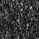

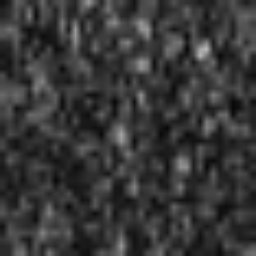

In [ ]:
from google.colab.patches import cv2_imshow
imgcomp = cv2.imread("noisy.png")
imgcomp = cv2.cvtColor(imgcomp, cv2.COLOR_BGR2GRAY)
Homogenousregion=imgcomp[90:129,145:184]
Tamura=np.sqrt(np.std(Homogenousregion)/np.mean(Homogenousregion))
print(Tamura)

cv2_imshow(imgcomp[90:129,145:184])
cv2_imshow(cv2.resize(imgcomp[90:129,145:184],(256,256)))

# Getting all the images

In [ ]:
pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 57.6 MB/s 


In [ ]:
#From tiff to png
import os
import rasterio
import cv2

def listaArchivos(path):
  """This function gets all the files in a directory"""
  filelist=[]
  with os.scandir(path) as entries:
      for i in entries:
        filelist.append(i.name)
  return filelist

path="tifffiles"
listaimagenes=listaArchivos(path)
cont=0
for i in listaimagenes:
  R=path+'/'+i
# Reading a tiff file
  band_id = 1  # this assumes you want the first band, change to match the band number you want
  raster = rasterio.open(R)
  band_arr = raster.read(band_id) 
  name=i.split(".")[0]+".png"
  cv2.imwrite(name, band_arr)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
#NLM
import cv2
import numpy as np
from skimage import io, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma




def NLM(Newimg1,Fast=True): # Library nonlocal means function
  """Function that computes scikit nonlocal means"""
  Newimg1=Newimg1 # Converting the tensor to numpy
  sigma_est = np.mean(estimate_sigma(Newimg1, multichannel=True))
  denoise_img2 = denoise_nl_means(Newimg1, h=1 * sigma_est, fast_mode=Fast, patch_size=5, patch_distance=3, multichannel=False)
  return denoise_img2


im1=cv2.imread("Squares1.png")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
ims2 = NLM(im1)
cv2.imwrite("NLMskimage.png", ims2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Image dtype is not float. By default denoise_nl_means will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.19 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  


True

In [ ]:
im1=cv2.imread("Squares1.png")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)


cv2.imwrite("Squares1_0.png", im1[0:256,:256])
cv2.imwrite("Squares1_1.png", im1[0:256,256:512])
cv2.imwrite("Squares1_2.png", im1[256:512,:256])
cv2.imwrite("Squares1_3.png", im1[256:512,256:512])

True

In [ ]:
# TMP average
import cv2
import numpy as np

ims=[]
im1=cv2.imread("Squares1.png")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
ims.append(im1)
im2=cv2.imread("Squares2.png")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
ims.append(im2)
im3=cv2.imread("Squares3.png")
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
ims.append(im3)
im4=cv2.imread("Squares4.png")
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)
ims.append(im4)
im5=cv2.imread("Squares5.png")
im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2GRAY)
ims.append(im5)
im6=cv2.imread("Squares6.png")
im6 = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
ims.append(im6)
im7=cv2.imread("Squares7.png")
im7 = cv2.cvtColor(im7, cv2.COLOR_BGR2GRAY)
ims.append(im7)
im8=cv2.imread("Squares8.png")
im8 = cv2.cvtColor(im8, cv2.COLOR_BGR2GRAY)
ims.append(im8)

avg=np.average(ims,axis=0)
cv2.imwrite("Temp_avg.png", avg)

True

In [ ]:
# zooming

import os
import cv2

def listaArchivos(path):
  """This function gets all the files in a directory"""
  filelist=[]
  with os.scandir(path) as entries:
      for i in entries:
        filelist.append(i.name)
  return filelist

path="Corner"
listaimagenes=listaArchivos(path)
cont=0
for i in listaimagenes:
  R=path+'/'+i
# Reading a tiff file
  im1=cv2.imread(R)
  im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im1=im1[78:178,78:178]
  name=i.split(".")[0]+".png"
  cv2.imwrite(name, cv2.resize(im1,(256,256)))

In [ ]:
# Missing:

# Metrics benchmark explain all this

# select filter upon usage of filter and weigh metrics,talk about how to use an example to select with the segmentation

# tablemetrics with colors and range

# normalize metrics

#How to visualize 9,9,9.9?

# Correcciones

# repeat the squares prediction

# validation metrics and some graphs from the training missing

# Wait for the new dataset 50000 images are done by now, and try again

# Resumen y abstract

# Add to antecedentes mas de SAR